# **Face Mask Classification**

## Introduction
Mask wearing has been one of the most impactful preventative measures during the covid-19 pandemic, with studies indicating the practice upon widespread adoption can reduce infections amongst the public by 47%. It has been shown however that gaps in mask compliance can create vulnerabilities to infection due to less herd protection. Within our project we proposed and implemented a neural net model capable of using computer vision to identify masked from non-masked individuals, in doing so creating a tool to accurately monitor mask compliance in a cost-effective manner. We believe our model can allow health authorities to better assess and manage the safety of large gatherings like sports and music events, with further use cases in PPE compliance across a diverse set of workplace environments.



### Libraries used
Most of the libraries used come from tensorflow's keras, which cater specifically to neural network task. These include a variety of functionalities that are crucial to an image classification problem, from image data processing to providing different layers architecture for our model(s). The details of how these are used will be discussed later on in their dedicated sections.
Additional supporting libraries are also used, like `numpy` to specify a random seed, `os` to help with data pathing and `matplotlib` to plot various results.

In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from time import time
np.random.seed(3000)

## Data analysis

### Dataset preparation
The rise of covid and face mask restrictions in past years had led to significant increases in facemask related datasets. Thus there are extensive options in selecting a dataset fit for this problem. The dataset we are using comes from Kaggle and is originally used for Facemask Detection. The data is in two folders, with_facemask and without_facemask. As we want to have separate Training & Validation and Test data we need to create a separate folder structure. For this reason and also for ease of collaboration through Google Collab, we have uploaded the dataset to a google drive which can be downloaded [here](https://drive.google.com/uc?id=1D5HoJK4V1GHBtkDSikjwFB134aHgwEOI). The dataset can then be unzip and put in the same directory as the notebook for the notebook to work.

This can also be accomplished by running the code cell below once.

In [ ]:
!gdown --id 1D5HoJK4V1GHBtkDSikjwFB134aHgwEOI
!unzip -q data.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1D5HoJK4V1GHBtkDSikjwFB134aHgwEOI
To: /content/data.zip
100% 171M/171M [00:00<00:00, 269MB/s]
replace Test/with_mask/with_mask_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


The code block below is a sanity check to ensure that we are running our work on GPUs.

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Some pathing initialisations with the help of the os libraries. This also helps us extract the number of images belong to each class.

In [ ]:
notebook_path = os.path.abspath("InceptionV3.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "TrainandVal")
masked_data = os.path.join(data_path, "with_mask")
unmasked_data = os.path.join(data_path, "without_mask")
test_data = os.path.join(os.path.dirname(notebook_path), "Test")

print("Training and Validation")
with_mask_len = len(os.listdir(masked_data))
print(f"Number of pictures with face masks {with_mask_len}")

without_mask_len = len(os.listdir(unmasked_data))
print(f"Number of pictures without face masks {without_mask_len}")

print("Test")
test_with_mask_len = len(os.listdir(os.path.join(test_data, "without_mask")))
print(f"Number of pictures with face masks {test_with_mask_len}")

test_without_mask_len = len(os.listdir(os.path.join(test_data, "with_mask")))
print(f"Number of pictures without face masks {test_without_mask_len}")

Training and Validation
Number of pictures with face masks 3590
Number of pictures without face masks 3693
Test
Number of pictures with face masks 135
Number of pictures without face masks 135


Extracting data and getting number of classes and class names

In [ ]:
data = tf.keras.preprocessing.image_dataset_from_directory(data_path)

Found 7283 files belonging to 2 classes.


In [ ]:
num_classes = len(data.class_names)
print('Number of Classes : {}'.format(num_classes))
class_names = data.class_names
class_names

Number of Classes : 2


['with_mask', 'without_mask']

Here matplotlib is used to visualise the data distribution of the main folder as well as the test folder.

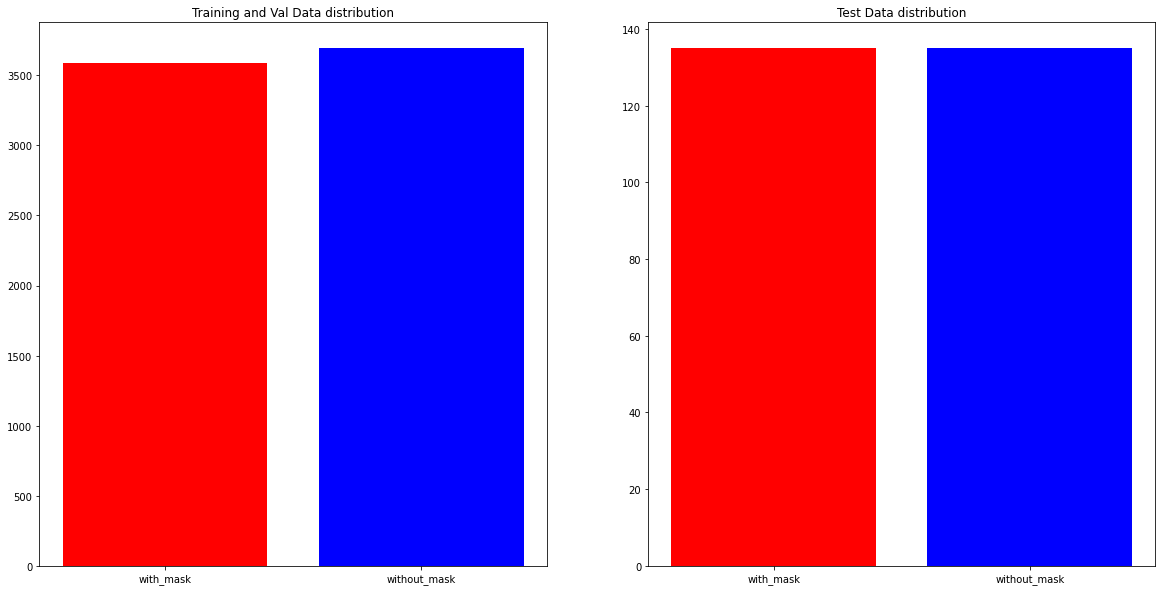

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Training and Val Data distribution')
plt.bar(class_names, [with_mask_len, without_mask_len], color=['red', 'blue'])
plt.subplot(1,2,2)
plt.title('Test Data distribution')
plt.bar(class_names, [test_with_mask_len, test_without_mask_len], color=['red', 'blue'])
plt.show()

We consider this distribution to be a fair balance, so no further sampling will be needed for the next data pre-processing stage.

### Data preprocessing
Limited preprocessing of the data was required as the data has been
We will use a data generator to feed the data into our model by using ImageDataGenerator. This will also generate real time data augmentation, since our dataset is not very large so it is important to introduce some diversity. We specified `horizontal_flip = True` to randomly flip the inputs horizontally.

The inputs pixel values will also be rescaled to a [0, 1] range instead of being kept at [0, 255] not only because that is what our model expects, but also because it is always a good idea to do normalization for a neural network.

By using `validation_split=0.2`, the dataset will be split into a ratio of 80%-20% for training and validation. We will then use `flow_from_directory` with specified `subset` parameter to generate training dataset and validation dataset respectively.

In [ ]:
img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./225,validation_split=0.2)

train_data = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset = 'training')

val_data = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset = 'validation')

Found 5827 images belonging to 2 classes.
Found 1456 images belonging to 2 classes.


Displaying random images from our dataset.

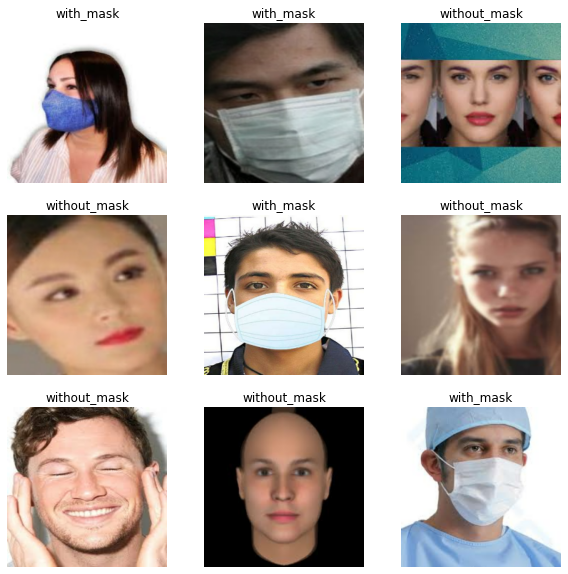

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")
        plt.title(class_names[labels[i]])

## Model(s) and Method(s)



### Prelimary models

The task is to perform binary classification of images of faces with and without face masks. Convolutional Neural Network are selected as these have shown to be adept in image classification tasks. The following models were considered as the backbone of our project.

#### AlexNet
AlexNet was the first CNN to win ImageNet. Its main strength was its ability to use multiple GPUs to increase its training performance allowing it to train its huge number of parameters.  

#### A Note on Transfer Learning
The next three models all utilise transfer learning, which allows us to use knowledge gained by a model through days of training on a large dataset such as ImageNet using high end GPUs and apply it to another task and smaller dataset. The early convolutional layers extract generalised low-level features such as edges, corners, patterns, and gradients that are applicable to any classification task. It is the later layers that identify features which are implementation specific such eyes and face masks.Thus for transfer learning we use the weights from the model pretrained using ImageNet and freeze the early layers. This way the model only needs to train a much smaller number of parameters to complete the classification task.  

#### RestNet50
Resnet 50 is a CNN that is pretrained on ImageNet. When creating deeper CNN to solve more complex tasks, the accuracy can be saturated or decrease. This can be due to vanishing or exploding gradients. Resnet was created to solve this problem and makes use of residual blocks to use skip connections, allowing gradients to pass through additional shortcut channels. The changes ResNet50 made to previous iterations was the shortcut connections skipped 3 layers instead of 2.  

#### InceptionNetV3
InceptionNet v3 is another CNN that is pretrained on the ImageNet database and started as a module for google net. CNN image classification features can vary greatly in size and location on the image which makes choosing a kernel size for convolutional operations difficult. InceptionNet was created to solve this problem by having filters with multiple sizes on the same level with a max pooling layer. This results in the model being wider rather than deeper.  

#### MobileNetV2
MobileNetV2 is a CNN designed to work on mobile devices. It uses depth wise separable convolutions to build a lightweight network tailored to less powerful devices.

### Testing and results

Each of these models were adapted to our classification task and the results tabulated. The code for these models is provided in separate files in the Other Models folder. The results are shown below:

|      Models     | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
|:---------------:|:-----------------:|:-------------------:|:-------------:|:---------------:|
|     AlexNet     |       0.9959      |        0.9187       |     0.0327    |      0.3824     |
|     ResNet50    |      0.7549       |       0.7470        |    0.1268     |     0.1691      |
| InceptionNetV3  |      0.9781      |       0.9821        |    0.0687     |     0.0547      |
|   MobileNetV2   |      0.9978       |       0.9911        |    0.0058     |     0.0337      |

The results suggest that InceptionNet and MobileNet are the best suited models for this task. We decided to choose InceptioNet as this gave us room for improving upon the base model.

### Chosen Model - InceptionNetV3


InceptionV3, originally named GoogleNet, is the third iteration of a convolutional neural network architecture and first introduced by Google. The network was able to achieve the best results in ImageNet Large Scale Visual Recognition Challenge 2014. It was known as a breakthrough in neural network models with its low number of parameters.
The network was originally proposed first as GoogleNet or InceptionV1. The premise was that in image classification problems, the important parts needed to do the classification in images can varies greatly in size and location, making the choosing of kernel size for convolutional operation a challenge. Besides, stacking multiple convolutional layers would only make the network become deeper and more expensive to compute (Back then some networks were still applying this logic in order to achieve a better performance).
The solution proposed was to have filters with multiple sizes on the same level (1x1, 3x3, 5x5) with an additional max pooling layer. To make it cheaper to compute, there were also extra 1x1 convolution layer added in before the 3x3 and 5x5 layers. These 1x1 layers were cheaper to compute and help reducing the number of input channels.

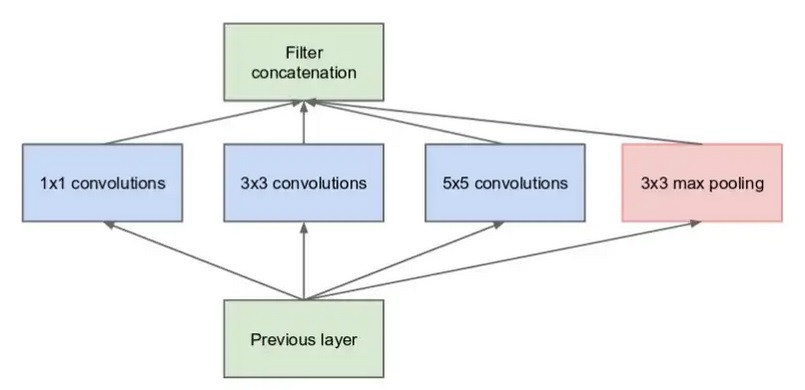


InceptionV2 and then subsequently InceptionV3 was introduced in the same paper with several upgrades compare to the first iteration. Some notable improvement includes:


*   Factorization: the use of smart factorization methods helps with computational complexity. For example, a `nxn` size convolution filter is factorised into a `nx1` and `1xn` filter, which was found to be 33% cheaper.
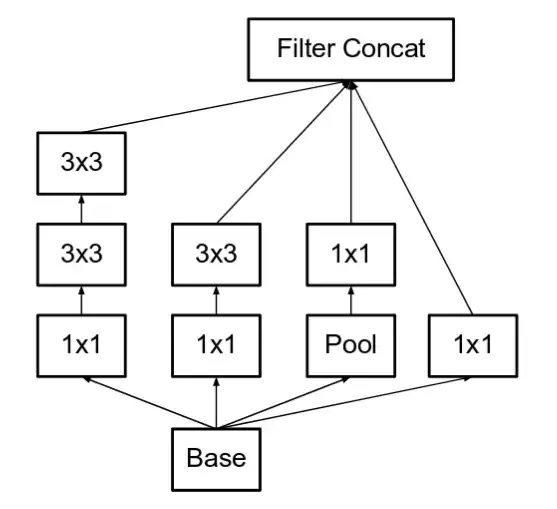
*   RMSProp Optimizer
*   BatchNormalisation

Here we load pre-trained InceptionV3 and set ```include_top = False``` which lets us leaves the last fully connected layer out as it is specific to the ImageNet competition.

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

### Changes

As mentioned above when we used ```include_top = False```, the final layers of the pre-trained model won't be used. Instead, we will need to build a final fully connected layers that caters to our specific problem and dataset.

We start with standardizing the input image to our desire shape of (150, 150, 3) before inserting it into our base model. Setting training = False for base_model is an important step because this will make the BatchNormalisation layer not update its mean and variance. This will be helpful when it comes to fine tuning our model later on.

Our final layers will consist of the followings:

- GlobalAveragePoooling2D to convert the features into a 2048-element vector for each image, from a 3x3 spatial location (as can be seen from the last layer in our model summary above).
- A Dropout layer to prevent overfitting on training data
- A dense layer of one unit with an activation function

https://keras.io/guides/transfer_learning/

https://www.tensorflow.org/tutorials/images/transfer_learning

The model with the final layer will then be compiled with an optimizer at a specified learning rate, with a specific loss function. These hyper parameters need to be selected appropriately to ensure the best performance of our model. Research into these parameters in the context of binary image classification produced a number of options.

To determine the best parameters an optimisation framework for hypertuning  called KerasTuner is utilised.

This comes with tuning algorithms like RandomSearch, BayesianOptimization and Hyperband. Each algorithm has its own advantages and disadvantages, and most of the time that is dependent on the dataset. This project uses the Hyperband tuner, which seem to have a middle ground performance between RandomSearch and BayesianOptimization (https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f).

What Hyperband essentially does is randomly sample all the combinations of hyperparameter, and speeds up the process by iteratively training the model for only a few epochs and select the best candidates according to the results of those epochs. Eventually, it will run the full training and evaluation process on the chosen candidates.

The code utilised for this tuning is in the *InceptionNetV3 Tuning* file.

The hyperparameters or attributes that will be tuned using this method are:
- Dropout layer with dropout rate: a value between 0.0, 0.2 and 0.5 (As it was suggested that we should not go higher than 50%)
- Activation method for the Dense layer: 'sigmoid', 'relu', 'softmax', 'tanh'
- The loss function: will be chosen between 'binary_crossentropy', 'binary_focal_crossentropy', 'log_cosh' - some of the popular loss function for binary classification problem.
- The optimizers: will be chosen between 'sgd', 'rmsprop', 'adam' - some of the popular optimizer for CNN.
- The learning rate for an optimizer: a value range from 0,0001 to 0.01.

The results of this process are provided in the figure below

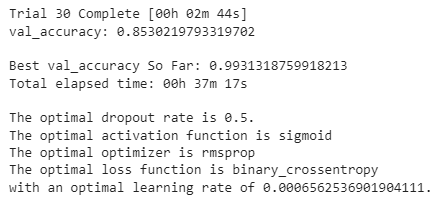

We will implement the build_model function with these parameters then compile and train it.

In [ ]:
from keras.optimizers import Adam, RMSprop, SGD
inputs = tf.keras.Input(shape=(150,150,3))
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer=RMSprop(learning_rate=0.0006562),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
st_time = time()
history = model.fit(train_data, epochs=50, validation_data=val_data, steps_per_epoch=100)
end_time = time()
print("Time taken: ",end_time-st_time)

Epoch 1/50
 93/100 [==========================>...] - ETA: 0s - loss: 0.2232 - accuracy: 0.9076

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 23s 151ms/step - loss: 0.2140 - accuracy: 0.9116 - val_loss: 0.0497 - val_accuracy: 0.9828
Epoch 2/50
100/100 [==============================] - 13s 133ms/step - loss: 0.0871 - accuracy: 0.9691 - val_loss: 0.0476 - val_accuracy: 0.9835
Epoch 3/50
100/100 [==============================] - 15s 145ms/step - loss: 0.0773 - accuracy: 0.9732 - val_loss: 0.0330 - val_accuracy: 0.9890
Epoch 4/50
100/100 [==============================] - 13s 129ms/step - loss: 0.0550 - accuracy: 0.9798 - val_loss: 0.0388 - val_accuracy: 0.9883
Epoch 5/50
100/100 [==============================] - 14s 137ms/step - loss: 0.0633 - accuracy: 0.9809 - val_loss: 0.0418 - val_accuracy: 0.9856
Epoch 6/50
100/100 [==============================] - 13s 133ms/step - loss: 0.0423 - accuracy: 0.9847 - val_loss: 0.0419 - val_accuracy: 0.9863
Epoch 7/50
100/100 [==============================] - 13s 126ms/step - loss: 0.0575 - accuracy: 0.9766 - val_loss: 0.0240 - val_accuracy: 0.9

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_____________________________________________

#### Results from Hypertuning


The accuracy and loss from training and validation are plotted below

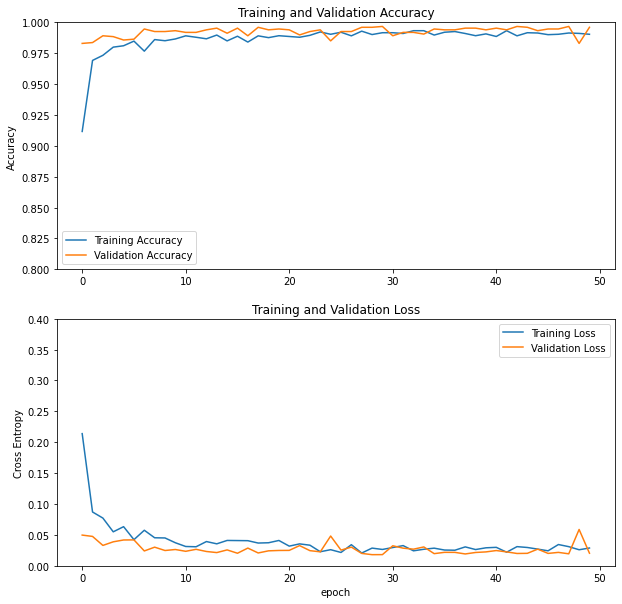

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.4])
plt.legend(loc='best')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

model.save('inv3.h5')

In [ ]:
test_data_path = os.path.join(os.path.dirname(notebook_path), "Test")
test_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_data_path, target_size=(150,150), batch_size=batch_size, class_mode='binary')
r = model.evaluate(test_data)
print(model.metrics_names)
print(r)

Found 270 images belonging to 2 classes.
9/9 [==============================] - 1s 145ms/step - loss: 0.0413 - accuracy: 0.9778
['loss', 'accuracy']
[0.04126443341374397, 0.9777777791023254]


The graphs show the model converges and the test accuracy is improved

#### Fine Tuning

The model has its previous layers frozen, so it does not reinitialise its learned weights (from transfer learning). Now to fine tune the model to our task, some of the specialised upper layers are unfrozen, this is because in a convolutional network the layers and feature extraction becomes more specific to the dataset, and these should be adapted to the dataset that we are using. The number of layers to be unfrozen depends on the specific problem and dataset, in this case through trial and error, 21 has been chosen.

In [ ]:
base_model.trainable = True

In [ ]:
# How many layers are in the base model?
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [ ]:
# Fine-tune from this layer onwards
un_freeze = 21

fine_tune_at = len(base_model.layers)-un_freeze

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

The model is now compiled again, with a lowered learning rate as there are more parameters to train and the accuracy is already very high, so the weights only need very slight adjustments

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.000006562),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,379,777
Non-trainable params: 19,425,056
_________________________________________

As the model’s accuracy is already very high, only a small amount of fine tuning is required and thus the additional epochs are set to 20 giving a total of 70 epochs. To decrease training time a call back for stopping early has been implemented and stops the training if the validation loss does not decrease for 5 epochs.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

st_time = time()

history_fine = model.fit(train_data,
                         epochs=70,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data,
                         steps_per_epoch=100,
                         callbacks=[stop_early]
                         )
#uncomment initial_epoch line if you want the training to continue

end_time = time()
print("Time taken: ",end_time-st_time)

Epoch 50/70
100/100 [==============================] - 19s 144ms/step - loss: 0.0309 - accuracy: 0.9927 - val_loss: 0.0288 - val_accuracy: 0.9918
Epoch 51/70
100/100 [==============================] - 13s 131ms/step - loss: 0.0193 - accuracy: 0.9946 - val_loss: 0.0228 - val_accuracy: 0.9945
Epoch 52/70
100/100 [==============================] - 17s 174ms/step - loss: 0.0213 - accuracy: 0.9921 - val_loss: 0.0232 - val_accuracy: 0.9952
Epoch 53/70
100/100 [==============================] - 14s 144ms/step - loss: 0.0189 - accuracy: 0.9950 - val_loss: 0.0223 - val_accuracy: 0.9966
Epoch 54/70
100/100 [==============================] - 12s 124ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0295 - val_accuracy: 0.9924
Epoch 55/70
100/100 [==============================] - 13s 131ms/step - loss: 0.0231 - accuracy: 0.9940 - val_loss: 0.0196 - val_accuracy: 0.9959
Epoch 56/70
100/100 [==============================] - 14s 135ms/step - loss: 0.0169 - accuracy: 0.9941 - val_loss: 0.0226 -

## Results

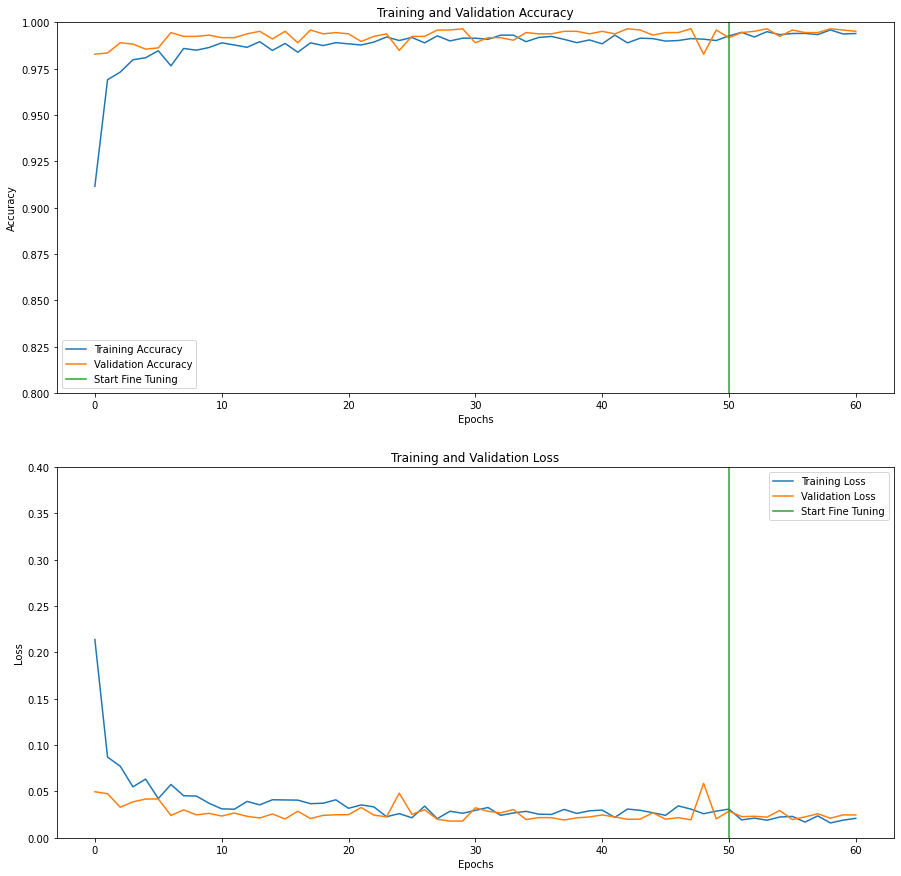

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([50,50],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.4])
plt.plot([50,50],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

model.save('inv3.h5')

In [ ]:
r = model.evaluate(test_data)
print(model.metrics_names)
print(r)

9/9 [==============================] - 1s 51ms/step - loss: 0.0147 - accuracy: 0.9926
['loss', 'accuracy']
[0.014699076302349567, 0.9925925731658936]


In order to facilitate comparison and observation, we have fine-tuned after epoch 50, so we can clearly see the difference between the optimised InceptionNetv3 framework and the fine-tuned in the figure. It converges to about 99% test and validation accuracy through the initial training however some small fluctuations remain. However, after epoch 50 the small flatten out and stabilises at an accuracy around 99.6%.
And for the loss of training and validation is almost the same phenomenon as the accuracy, after fine-tuning the value are more convergent and smoother than the original which have not been fine-tuned.
The test results for both the final model presented above and the initial model from the preliminary models section are tabulated below.


|                | Test Accuracy  | Test Loss  |
|----------------|----------------|------------|
| Before tuning  | 0.9333         | 0.1494     |
| After tuning   | 0.9926         | 0.0147     |

### Examples

Examples of images with the model prediciton are given below

In [ ]:
test_data_path = os.path.join(os.path.dirname(notebook_path), "Test")
test_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_data_path, target_size=(150,150), batch_size=batch_size, class_mode='binary')

Found 270 images belonging to 2 classes.


tf.Tensor([0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0], shape=(32,), dtype=int32)


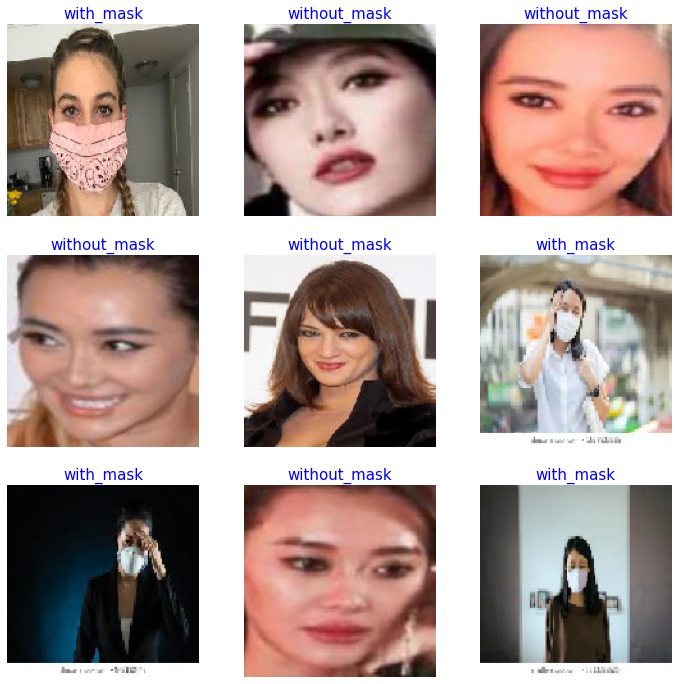

In [ ]:
import tensorflow as tf
from keras.preprocessing import image
from keras.models import load_model

saved_model = load_model("inv3.h5")

image_batch, label_batch = next(test_data)
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)
plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[predictions[i]], size=15, color='blue')
  plt.axis("off")

## Discussion

The result achieved with the improved model is exceptional with a test accuracy of 99.3%. From the results graphs it can be seen that the model converges to 98% after around 20 epochs there it remains stable until fine tuning begins at epoch 50. Here fluctuations are reduced, and a very slight uptrend begins. Call-backs are used to stop the training when validation accuracy ceases to improve after 5 epochs as there is very little room for more growth here. The model prior to fine tuning has 2,049 trainable parameters which is not a significantly large amount. This is a strength of models that can make use of transfer learning such as this one and provide a high initial accuracy as seen in the graphs and do not require a large number of epochs to converge. During fine tuning after the layers have been unfrozen the number of trainable parameters increases to 2,379,777. This noticeably increases the training time required. The initial training time is approximately 14 minutes and 30 seconds, with the addition of fine tuning this becomes 16 minutes and 30 seconds.
There is possibility for future work in this model to improve both accuracy and training time. The number of layers set to trainable was not studied in depth and only a few options were arbitrability tested before arriving on 21 layers. Finding an optimal value for layers that need to be trained could increase accuracy of the model or decrease the training time. Additionally, an optimal learning rate was found for the initial training, however in the fine tuning as the weights only need minimal adjustment a lowered learning rate is beneficial. The rate chosen was an arbitrary 1/100 of the original learning rate. Finding an optimal rate for could also improve accuracy of the model.